# jaxpulse Testing

In [1]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from jaxpulse.controllers import ControlVector, SinusoidalControl, ConstantControl, FrequencyControl, GaussianControl, GaussianPulseTrain, GaussianShapeControl, GaussianHeightControl
from jaxpulse.optimizers import ClosedQuantumSystem, OpenQuantumSystem, OptimalController
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

### Simple Qubit Flip Pulse Control

In [ ]:
tls = ClosedQuantumSystem(
    H_0=dq.eye(2),
    H_M=[dq.sigmax()]
)
proj1 = dq.fock_dm(2,1)
proj0 = dq.fock_dm(2,0)
ctrl = OptimalController(
    system=tls,
    controls=ControlVector([GaussianHeightControl( # see also GaussianControl, GaussianShapeControl
        amp=jnp.array([1.0]),
        mean=jnp.array([7.0]),
        sigma=jnp.array([1.0]),
    )]),
    y0=dq.fock(2,0),
    duration=15.0,
    y_final=lambda psi_T: 1 - dq.expect(proj1, psi_T),
)
figpre,axpre = plt.subplots()
ctrl.plot(ax=axpre, exp_ops=[proj0],exp_names=["<0>"])
axpre.legend()
figpre.show()

In [ ]:
ctrl2 = ctrl.optimize(N_steps=25,verbosity=2.0)

In [ ]:

figpost, axpost = plt.subplots()
ctrl2.plot(ax=axpost,exp_ops=[proj0],exp_names=["<0>"])
axpost.legend()
figpost.show()

### Ancilla Reset Pulse Control

In [18]:
proj0 = dq.fock_dm(2,0)
proj1 = dq.fock_dm(2,1)
Delta = 1.
duration = 10.0
rho0 = dq.fock_dm(2,1)
gamma = 5
H_0 = dq.eye(2)
amp0 = jnp.sqrt(gamma)*dq.destroy(2)
tls = OpenQuantumSystem(
    H_0=H_0,
    H_M=[],
    U_K=[],
    C_K=[amp0]
)
loss_gaussian = ControlVector([
    GaussianHeightControl(
        amp=jnp.array([.5]),
        mean=jnp.array([duration/2]),
        sigma=jnp.array([.1])
    )
])
resetter = OptimalController(
    system=tls,
    controls=loss_gaussian,
    y0=rho0,
    duration=duration,
    y_final= lambda y: 1 - dq.expect(proj0, y)
)

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_39080/2490421529.py:9: SyntaxWarning: invalid escape sequence '\h'
/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_39080/2490421529.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


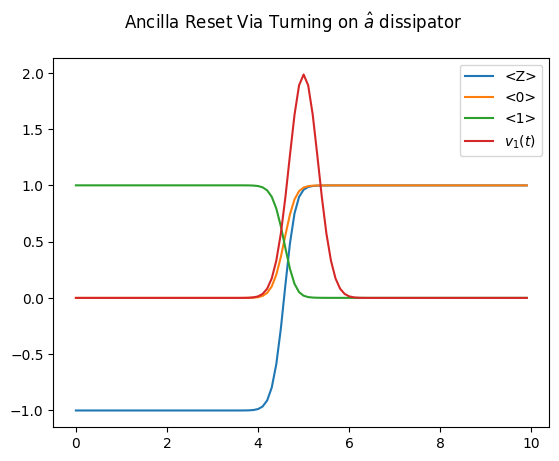

In [19]:
figpre, axpre = plt.subplots()
resetter.plot(
    ax=axpre,
    exp_ops=[dq.sigmaz(),proj0,proj1],
    exp_names=["<Z>","<0>","<1>"]
)
states = resetter.run(controls=loss_gaussian)
axpre.legend()
figpre.suptitle("Ancilla Reset Via Turning on $\hat{a}$ dissipator")
figpre.show()


### Optimal Control on Simple Systems: Driven JC Model

#### System Setup

In [ ]:
N_res = 4
N_qub = 2
omega_res = 3.0
omega_qub = 2.2
g = .1

a = dq.tensor(dq.destroy(N_res), dq.eye(N_qub))
b = dq.tensor(dq.eye(N_res), dq.destroy(N_qub))
Z = dq.tensor(dq.eye(N_res), dq.number(N_qub))
H_0 = omega_res * dq.dag(a)@a + omega_qub * dq.dag(b)@b # static Hamiltonian
H_1 = dq.dag(a) @ b + a @ dq.dag(b) # coupling
H_2 = 1./jnp.sqrt(2)*(a + dq.dag(a)) # X
H_3 = 1j/jnp.sqrt(2)*(dq.dag(a) - a) # P
H_M = [H_1, H_2]
psi_0 = dq.tensor(dq.fock(N_res,0),dq.fock(N_qub,0))


#### Control Setups

In [ ]:
coupling_control = GaussianControl(
    amp=jnp.array([1.0, 1.0]),
    mean=jnp.array([5.0, 10.0]),
    sigma=jnp.array([1.0, 1.0])
)
drive_X = GaussianControl(
    amp=jnp.ones((4,)),
    mean=jnp.linspace(2,12,4),
    sigma=jnp.ones((4,))
)
drive_X = GaussianPulseTrain(
    amp =jnp.array([1.0]),
    mean=jnp.array([4.0]),
    sigma=jnp.array([.5]),
    period=jnp.array([6.0])
)

#### Optimizer Setup

In [ ]:
jc_system = ClosedQuantumSystem(
    H_0=H_0,
    H_M=H_M
)

jc_controls = ControlVector(
    [
        coupling_control,
        drive_X,
    ]
)

def final_penalty(psi_tF: Array) -> float:
    return 1 - dq.expect(Z, psi_tF)

duration= 15.0
controller = OptimalController(
    system=jc_system,
    controls=jc_controls,
    y0=psi_0,
    duration=duration,
    dt_start=.01,
    dt_save=.1,
    y_final=final_penalty,
)

#### Pre-Training

In [ ]:
fig, ax = plt.subplots()
controller.plot(
    ax=ax,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"],
)
fig.legend()
fig.show()

#### Training

In [ ]:
new_controller = controller.optimize(
    N_steps=40,
    learning_rate=.1,
    verbosity=2,
)

#### Post-Training

In [ ]:
fig_opt, ax_opt = plt.subplots()
new_controller.plot(
    ax_opt,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"]
)
fig_opt.legend()
fig_opt.suptitle("Optimized Pulses For Driven Jaynes-Cummings Model")
fig_opt.show()

### Open System Demos

In [ ]:
U_0 = jnp.sqrt(.1)*a
open_sys = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[U_0],
    C_K=[]
)
open_controls = jc_controls

open_controller = OptimalController(
    system=open_sys,
    controls=open_controls,
    y0=dq.todm(psi_0),
    duration=duration,
    y_final=final_penalty
)

#### Pre-Train

In [ ]:
fig_pre, ax_pre = plt.subplots()
open_controller.plot(
    ax=ax_pre,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"],
)
fig_pre.legend()
fig_pre.show()

#### Train

In [ ]:
opt_open_controller = open_controller.optimize(
    N_steps=100,
    verbosity=2,
)

#### Post-Train

In [ ]:
fig_open_opt, ax_open_opt = plt.subplots()
opt_open_controller.plot(
    ax_open_opt,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"]
)
fig_open_opt.legend()
fig_open_opt.suptitle("Optimized Pulses For Driven Jaynes-Cummings Model")
fig_open_opt.show()
